In [1]:
from IPython.display import IFrame
IFrame('project2.pdf', width=800, height=1600)

In [2]:
# Import statements
import os, sys

# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

from keras.models import Model
from keras.utils import Sequence
from keras.layers import Input, LSTM, GRU, Dense, Embedding,\
                         Bidirectional, RepeatVector, Concatenate,\
                         Activation, Dot, Lambda
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras.backend as K

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

c:\program files\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# Config variables
BATCH_SIZE = 64
EPOCHS = 15 #100
LATENT_DIM = 256
LATENT_DIM_DECODER = 256 # idea: make it different to ensure things all fit together properly!
NUM_SAMPLES = 80000
MAX_INPUT_LENGTH = 100
MAX_TARGET_LENGTH = 25
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
SPLIT_IDX = int(NUM_SAMPLES * VALIDATION_SPLIT)

In [4]:
# make sure we do softmax over the time axis
# expected shape is N x T x D
# note: the latest version of Keras allows you to pass in axis arg
def softmax_over_time(x):
  assert(K.ndim(x) > 2)
  e = K.exp(x - K.max(x, axis=1, keepdims=True))
  s = K.sum(e, axis=1, keepdims=True)
  return e / s

In [5]:
# Load pretrained word vectors for embeddings
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('./data/glove.6B/glove.6B.{}d.txt'.format(EMBEDDING_DIM)), encoding='utf8') as f:
    for row in f:
        values = row.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Loaded {} word vectors.'.format(len(word2vec)))

Loading word vectors...
Loaded 400001 word vectors.


In [6]:
# Load stories
train = pd.read_csv('./data/cloze/train_stories.csv')[:NUM_SAMPLES]
train = train.reindex(np.random.permutation(train.index))
titles = train['storytitle'].values
story_parts = train[['sentence1', 'sentence2', 'sentence3', 'sentence4']].values
stories = train['sentence1'] + ' ' + \
          train['sentence2'] + ' ' + \
          train['sentence3'] + ' ' + \
          train['sentence4'] + ' '
targets = train['sentence5'] + ' <eos> '
targets_inputs = ' <bos> ' +  train['sentence5']
print('Loaded {} stories.'.format(len(stories)))

Loaded 80000 stories.


In [7]:
# Tokenize
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=?@[\]^_`{|}~')
tokenizer.fit_on_texts(stories + targets + targets_inputs)
input_sequences = tokenizer.texts_to_sequences(stories)
target_sequences = tokenizer.texts_to_sequences(targets)
target_sequences_inputs = tokenizer.texts_to_sequences(targets_inputs)

# Word to index mapping and reverse
word2idx = tokenizer.word_index
idx2word = {v:k for k, v in word2idx.items()}
print('Generated {} unique tokens.'.format(len(word2idx)))

Generated 34483 unique tokens.


In [8]:
# Find max length input sequence
max_len_input = max(len(s) for s in input_sequences)
print('Longest story has {} tokens.'.format(max_len_input))

# Find max length target sequence
max_len_target = max(len(t) for t in target_sequences)
print('Longest target has {} tokens.'.format(max_len_target))

Longest story has 63 tokens.
Longest target has 20 tokens.


In [9]:
# Pad inputs
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input, padding='post', truncating='pre')
print('Inputs tensor has shape {}.'.format(encoder_inputs.shape))

# Pad target inputs
decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post', truncating='pre')
print('Target inputs tensor has shape {}.'.format(decoder_inputs.shape))

# Pad targets
decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post', truncating='pre')
print('Targets tensor has shape {}.'.format(decoder_targets.shape))

Inputs tensor has shape (80000, 63).
Target inputs tensor has shape (80000, 20).
Targets tensor has shape (80000, 20).


In [10]:
# Construct embedding matrix
print('Constructing embedding matrix...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, index in word2idx.items():
    if index < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
print('Embedding matrix has shape {}'.format(embedding_matrix.shape))

Constructing embedding matrix...
Embedding matrix has shape (20000, 100)


In [11]:
# Create embedding layers
encoder_embedding_layer = Embedding(num_words, EMBEDDING_DIM,
                                    weights=[embedding_matrix],
                                    input_length=max_len_input,
                                    trainable=False)

decoder_embedding_layer = Embedding(num_words, EMBEDDING_DIM,
                                    weights=[embedding_matrix],
                                    input_length=max_len_target,
                                    trainable=False)

In [12]:
class DataGenerator(Sequence):
    def __init__(self, x1_set, x2_set, y_set, batch_size=64):
        self.x1, self.x2, self.y = x1_set, x2_set, y_set
        self.batch_size = batch_size
    
    def __len__(self):
        return int(np.floor(len(self.x1) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x1 = self.x1[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x2 = self.x2[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y  =  self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y_one_hot = self.__one_hot(batch_y)
        batch_z = self.__generate_z()
        return [batch_x1, batch_x2, batch_z, batch_z], batch_y_one_hot
    
    def __one_hot(self, targets):
        targets_one_hot = np.zeros((len(targets),
                                    max_len_target,
                                    num_words))
        
        for i, d in enumerate(targets):
            for t, word in enumerate(d):
                targets_one_hot[i, t, word] = 1
        return targets_one_hot
         
    def __generate_z(self):
         return np.zeros((self.batch_size, LATENT_DIM_DECODER)) # initial [s, c]

In [13]:
### Assemble the model
## Encoder
# Embedding
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = encoder_embedding_layer(encoder_inputs_placeholder)

# RNN
encoder = Bidirectional(LSTM(LATENT_DIM, return_sequences=True, dropout=0.5))
encoder_outputs = encoder(x)

## Decoder
# Embedding
decoder_inputs_placeholder = Input(shape=(max_len_target,))
decoder_inputs_x = decoder_embedding_layer(decoder_inputs_placeholder)

# Attention
attn_repeat_layer = RepeatVector(max_len_input)
attn_concat_layer = Concatenate(axis=-1)
attn_dense1 = Dense(10, activation='tanh')
attn_dense2 = Dense(1, activation=softmax_over_time)
attn_dot = Dot(axes=1) # to perform the weighted sum of alpha[t] * h[t]

def one_step_attention(h, st_1):
    # h = h(1), ..., h(Tx), shape = (Tx, LATENT_DIM * 2)
    # st_1 = s(t-1), shape = (LATENT_DIM_DECODER,)

    # copy s(t-1) Tx times
    # now shape = (Tx, LATENT_DIM_DECODER)
    st_1 = attn_repeat_layer(st_1)

    # Concatenate all h(t)'s with s(t-1)
    # Now of shape (Tx, LATENT_DIM_DECODER + LATENT_DIM * 2)
    x = attn_concat_layer([h, st_1])

    # Neural net first layer
    x = attn_dense1(x)

    # Neural net second layer with special softmax over time
    alphas = attn_dense2(x)

    # "Dot" the alphas and the h's
    # Remember a.dot(b) = sum over a[t] * b[t]
    context = attn_dot([alphas, h])

    return context


# define the rest of the decoder (after attention)
decoder_lstm = LSTM(LATENT_DIM_DECODER, return_state=True)
decoder_dense = Dense(num_words, activation='softmax')

initial_s = Input(shape=(LATENT_DIM_DECODER,), name='s0')
initial_c = Input(shape=(LATENT_DIM_DECODER,), name='c0')
context_last_word_concat_layer = Concatenate(axis=2)


# Unlike previous seq2seq, we cannot get the output
# all in one step
# Instead we need to do Ty steps
# And in each of those steps, we need to consider
# all Tx h's

# s, c will be re-assigned in each iteration of the loop
s = initial_s
c = initial_c

# collect outputs in a list at first
outputs = []
for t in range(max_len_target): # Ty times
    # get the context using attention
    context = one_step_attention(encoder_outputs, s)

    # we need a different layer for each time step
    selector = Lambda(lambda x: x[:, t:t+1])
    xt = selector(decoder_inputs_x)

    # combine
    decoder_lstm_input = context_last_word_concat_layer([context, xt])

    # pass the combined [context, last word] into the LSTM
    # along with [s, c]
    # get the new [s, c] and output
    o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[s, c])

    # final dense layer to get next word prediction
    decoder_outputs = decoder_dense(o)
    outputs.append(decoder_outputs)


# 'outputs' is now a list of length Ty
# each element is of shape (batch size, output vocab size)
# therefore if we simply stack all the outputs into 1 tensor
# it would be of shape T x N x D
# we would like it to be of shape N x T x D

def stack_and_transpose(x):
    # x is a list of length T, each element is a batch_size x output_vocab_size tensor
    x = K.stack(x) # is now T x batch_size x output_vocab_size tensor
    x = K.permute_dimensions(x, pattern=(1, 0, 2)) # is now batch_size x T x output_vocab_size
    return x

# make it a layer
stacker = Lambda(stack_and_transpose)
outputs = stacker(outputs)

In [14]:
model = Model(inputs=[encoder_inputs_placeholder,
                      decoder_inputs_placeholder,
                      initial_s,
                      initial_c],
              outputs=outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# print(model.summary())

In [ ]:
# Training
training_generator = DataGenerator(encoder_inputs[SPLIT_IDX:],
                                   decoder_inputs[SPLIT_IDX:],
                                   decoder_targets[SPLIT_IDX:],
                                   batch_size=BATCH_SIZE)

validation_generator = DataGenerator(encoder_inputs[:SPLIT_IDX],
                                     decoder_inputs[:SPLIT_IDX],
                                     decoder_targets[:SPLIT_IDX],
                                     batch_size=BATCH_SIZE)

r = model.fit_generator(generator=training_generator,
                        validation_data=validation_generator,
                        epochs=EPOCHS,
                        shuffle=True,
                        initial_epoch=1,
                        verbose=1)

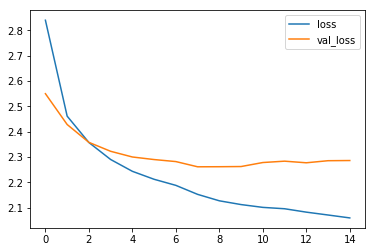

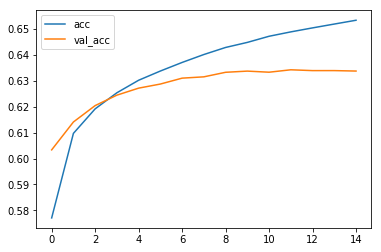

In [16]:
# Plot losses
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# Plot accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [ ]:
model.load('attn.h5')

In [ ]:
##### Make predictions #####
# As with the poetry example, we need to create another model
# that can take in the RNN state and previous word as input
# and accept a T=1 sequence.

# The encoder will be stand-alone
# From this we will get our initial decoder hidden state
# i.e. h(1), ..., h(Tx)
encoder_model = Model(encoder_inputs_placeholder, encoder_outputs)

# next we define a T=1 decoder model
encoder_outputs_as_input = Input(shape=(max_len_input, LATENT_DIM * 2,))
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

# no need to loop over attention steps this time because there is only one step
context = one_step_attention(encoder_outputs_as_input, initial_s)

# combine context with last word
decoder_lstm_input = context_last_word_concat_layer([context, decoder_inputs_single_x])

# lstm and final dense
o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[initial_s, initial_c])
decoder_outputs = decoder_dense(o)


# note: we don't really need the final stack and tranpose
# because there's only 1 output
# it is already of size N x D
# no need to make it 1 x N x D --> N x 1 x D



# create the model object
decoder_model = Model(
  inputs=[
    decoder_inputs_single,
    encoder_outputs_as_input,
    initial_s,
    initial_c
  ],
  outputs=[decoder_outputs, s, c]
)





def decode_sequence(input_seq):
  # Encode the input as state vectors.
  enc_out = encoder_model.predict(input_seq)

  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1, 1))

  # Populate the first character of target sequence with the start character.
  # NOTE: tokenizer lower-cases all words
  target_seq[0, 0] = word2idx['<bos>']

  # if we get this we break
  eos = word2idx['<eos>']


  # [s, c] will be updated in each loop iteration
  s = np.zeros((1, LATENT_DIM_DECODER))
  c = np.zeros((1, LATENT_DIM_DECODER))


  # Create the translation
  output_sentence = []
  for _ in range(max_len_target):
    o, s, c = decoder_model.predict([target_seq, enc_out, s, c])


    # Get next word
    idx = np.argmax(o.flatten())
    # End sentence of EOS
    if eos == idx:
      break

    word = ''
    if idx > 0:
      word = idx2word.get(idx, '')
      output_sentence.append(word)

    # Update the decoder input
    # which is just the word just generated
    target_seq[0, 0] = idx

  return ' '.join(output_sentence)




while True:
  # Do some test translations
  i = np.random.choice(len(stories))
  input_seq = encoder_inputs[i:i+1]
  ending = decode_sequence(input_seq)
  print('-')
  print('Input story:', stories[i])
  print('Predicted ending:', ending)
  print('Actual ending:', targets[i])

  ans = input("Continue? [Y/n]")
  if ans and ans.lower().startswith('n'):
    break


-
Input sentence: Tom was a middle school student. He signed up for a woodshop class. He learned a lot about making things with wood. He used many pieces of construction equipment. 
Predicted translation: sally was relieved and happy
Actual translation: He made a large wooden chair he brought home. <eos> 
Continue? [Y/n]y
-
Input sentence: Ed wanted to be a pilot. But at flight school, he did flight simulations. They made him nauseous! It turned out flight wasn't for Ed. 
Predicted translation: the man was the man and he was able to get the ball
Actual translation: He decided to choose a new career! <eos> 
Continue? [Y/n]y
-
Input sentence: The first date I remember was my first year in college. A girl and I went to a play at school. Then we ate at a Mexican restaurant. The restaurant was about to close. 
Predicted translation: dan was glad that he could not play his song
Actual translation: But a friend of mine thought she was into me. <eos> 
Continue? [Y/n]y
-
Input sentence: Tom had